# **FINE TUNING WITH ALL LAYERS UNFREEZED**

In this paper we are going to perform the fine tuning by unfreezing all the layers of our network.

## **Mount and unzipping**

At the beginning we allow the access to our Google Drive and then we unzip the dataset on our folder.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
'''
# Unzipping dataset
%cd '/content/gdrive/MyDrive/progetto/dbs/' 
!unzip -q original_facial_expression.zip
'''

/content/gdrive/.shortcut-targets-by-id/1IrDGYaOd_7sICD_EFnZIaiOAtwpfZeii/progetto/dbs


Now we import all the needed modules and we define the folders' path that we are going to use.

In [ ]:
import glob
import os
import numpy as np
import PIL
from PIL import ImageDraw, ImageOps, Image

import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import load_img
from keras.models import load_model

from IPython.display import display
from tqdm.notebook import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC

np.random.seed(42)
tf.random.set_seed(42)


BASE_DIR = '/content/gdrive/MyDrive/progetto/dbs/facial_expression/dataset'
TRAIN_DATA_DIR = os.path.join(BASE_DIR, 'Training')
TEST_DATA_DIR = os.path.join(BASE_DIR, 'PublicTest')

#TO DO: Define the correct batch size
BATCH_SIZE = 256

device_name = tf.test.gpu_device_name()
print('GPU: ', device_name)

GPU:  /device:GPU:0


## **Model loading**

Since our pretrained network doesn't belong to Keras, we are going to load the Inception ResNet v1 in the following way:

In [ ]:
facenet = load_model('/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/facenet_keras.h5')
facenet.load_weights('/content/gdrive/MyDrive/progetto/modello/keras-facenet/weights/facenet_keras_weights.h5')
print("Shape: ",facenet.output_shape)

Shape:  (None, 128)


## **Dataset Loading** 

We use *image_dataset_from_directory()* provided by Keras to load the image dataset. At the end we perform the *prefetch()* function to improve the performance in dataset loading. Thanks to *prefectch()*, while model is executing the step *s* of the training, input pipeline read data for the step *s+1*. In this way the time needed is `max(training_time, time_to_read_data)` instead of `training_time + time_to_read_data`. By using *tf.data.AUTOTUNE*, the value of the data's batch size is decided automatically at runtime.

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DATA_DIR,
    labels='inferred',
    label_mode='int',
    subset="training",
    validation_split=0.2,
    seed=123,
    image_size=(160, 160),
    batch_size=BATCH_SIZE,
    color_mode='rgb')

valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   TRAIN_DATA_DIR,
   labels='inferred',
   label_mode='int',
   subset="validation",
   shuffle=False,
   validation_split=0.2,
   seed=123,
   image_size=(160, 160),
   batch_size=BATCH_SIZE,
   color_mode='rgb')

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DATA_DIR,
    seed=123,
    labels='inferred',
    label_mode='int',
    shuffle=False,
    image_size=(160, 160),
    batch_size=BATCH_SIZE,
    color_mode='rgb')

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE)
testing_dataset = testing_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 3589 files belonging to 7 classes.


Now, we have a look to some image which are in our dataset.

(32, 160, 160, 3) (32,)
float32 0.0 255.0
[0 3 6 5 3]


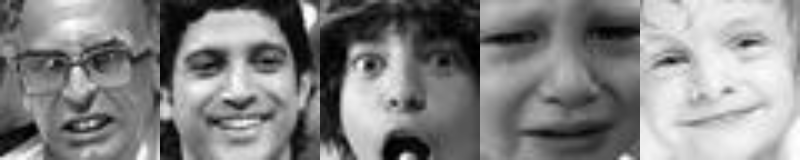

In [ ]:
# get the first batch from the streaming dataset
batch = next(iter(train_dataset))  
images, labels = batch
print(images.shape, labels.shape)

# inspect data type
images = images.numpy()
print(images.dtype, images.min(), images.max())  # float32, [0, 255]

# show some images
sample_labels = labels.numpy()[:5]
sample_images = np.hstack(images[:5])  # stack 5 images horizontally
sample_images = sample_images.astype(np.uint8)  # PIL wants uint8
sample_images = PIL.Image.fromarray(sample_images)  # to PIL image

print(sample_labels)
display(sample_images)

## **Training**

On the top of the pretrained network, we build our densly connected network. We have a *Flatten layer* that reshape the pretrained network's output. Then, we have two *Dense layers*: the first has 128 hidden layers with **ReLu** activation function while the last one has 7 layers (as the output class we have) with **softmax** activation function. Since we don't want to perform fine-tuning, hence we don't want to recompute the weights of the pretrained network, then we set `trainable = False`.




In [ ]:
facenet.trainable = False
model = Sequential()
#base model
model.add(L.Input(shape=(160,160,3)))
model.add(facenet)
model.add(L.Flatten())
model.add(L.Dense(128, activation="relu",name="classifier_hidden"))
model.add(L.Dense(7,activation = 'softmax'))

model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
classifier_hidden (Dense)    (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 903       
Total params: 22,825,559
Trainable params: 17,415
Non-trainable params: 22,808,144
_________________________________________________________________


Since we have many classes and an image belongs only to a specific class, we use the **sparse categorical crossentropy** as loss function. As optimizer, we use **RMSprop** with a very low **learning rate** and by using 0.6 **momentum**. In this way we do little step but thanks to momentum we can avoid local minima.




In [ ]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5, momentum=0.6),
              metrics=["acc"])

Here is important to highlight the number of **epochs** which are equal to 50.

In [ ]:
history = model.fit(
      train_dataset,
      epochs=50,
      validation_data=valid_dataset,
      use_multiprocessing=True,
      batch_size = BATCH_SIZE
      )

Epoch 1/50
90/90 [==============================] - 61s 584ms/step - loss: 1.8861 - acc: 0.2020 - val_loss: 2.0106 - val_acc: 0.0735
Epoch 2/50
90/90 [==============================] - 55s 573ms/step - loss: 1.8596 - acc: 0.2175 - val_loss: 2.0048 - val_acc: 0.0759
Epoch 3/50
90/90 [==============================] - 55s 568ms/step - loss: 1.8455 - acc: 0.2245 - val_loss: 2.0135 - val_acc: 0.0674
Epoch 4/50
90/90 [==============================] - 55s 574ms/step - loss: 1.8326 - acc: 0.2311 - val_loss: 1.9773 - val_acc: 0.0775
Epoch 5/50
90/90 [==============================] - 55s 570ms/step - loss: 1.8215 - acc: 0.2366 - val_loss: 1.9552 - val_acc: 0.0836
Epoch 6/50
90/90 [==============================] - 55s 574ms/step - loss: 1.8181 - acc: 0.2394 - val_loss: 1.9516 - val_acc: 0.0890
Epoch 7/50
90/90 [==============================] - 55s 571ms/step - loss: 1.8100 - acc: 0.2475 - val_loss: 1.9392 - val_acc: 0.1000
Epoch 8/50
90/90 [==============================] - 55s 569ms/step - 

## **Plot**
Now we plot the results obtained. We can observe a consistent overfitting and a low accuracy either in training results (a little less than 30%) and in testing results (equal to 29%).

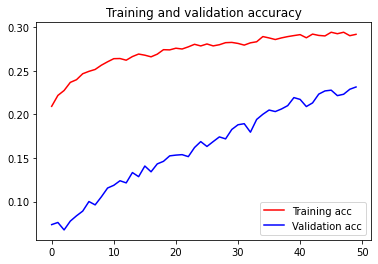

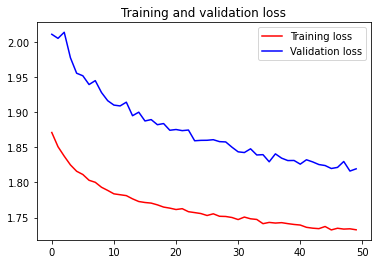

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# evaluate the model on the test set with evaluate() ...
test_loss, test_accuracy = model.evaluate(testing_dataset)
test_accuracy

15/15 [==============================] - 7s 447ms/step - loss: 1.7303 - acc: 0.2937


0.29367512464523315

## **Finetune the pretrained network**
We can try to improve these results by performing fine tuning. In particular, in this paper we try to fine tune the whole pretrained network by setting `trainable = True` without specifing any layer. To do this, again we load the pretrained network to don't overwrite previous results. Our densly connected network builds on the top of the pretrained network is the same we have seen before.

In [ ]:
facenet_tun = load_model('/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/facenet_keras.h5')
facenet_tun.load_weights('/content/gdrive/MyDrive/progetto/modello/keras-facenet/weights/facenet_keras_weights.h5')

In [ ]:
facenet_tun.trainable = True
model_tun = Sequential()
#base model
model_tun.add(L.Input(shape=(160,160,3)))
model_tun.add(facenet_tun)
model_tun.add(L.Flatten())
model_tun.add(L.Dense(128, activation="relu",name="classifier_hidden_tun"))
model_tun.add(L.Dense(7,activation = 'softmax'))

model_tun.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)               0         
_________________________________________________________________
classifier_hidden_tun (Dense (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 903       
Total params: 22,825,559
Trainable params: 22,796,727
Non-trainable params: 28,832
_________________________________________________________________


Since we have many classes and an image belongs only to a specific class, we use the **sparse categorical crossentropy** as loss function. As optimizer, we use **RMSprop** with a **learning rate** one order of magnitude less than before, because we are performing finetuning, and by using an higher **momentum** than before, equal to 0.7.


In [ ]:
model_tun.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-6, momentum=0.7),
              metrics=['accuracy'])

We perform finetuing in 50 epochs, again.

In [ ]:
fine_history = model_tun.fit(
      train_dataset,
      epochs=50,
      validation_data=valid_dataset,
      batch_size = BATCH_SIZE
      )

Epoch 1/50
90/90 [==============================] - 117s 1s/step - loss: 2.3679 - accuracy: 0.1137 - val_loss: 1.6649 - val_accuracy: 0.3916
Epoch 2/50
90/90 [==============================] - 105s 1s/step - loss: 2.2075 - accuracy: 0.1487 - val_loss: 1.5574 - val_accuracy: 0.4358
Epoch 3/50
90/90 [==============================] - 105s 1s/step - loss: 2.0747 - accuracy: 0.1927 - val_loss: 1.4745 - val_accuracy: 0.4851
Epoch 4/50
90/90 [==============================] - 104s 1s/step - loss: 1.9635 - accuracy: 0.2391 - val_loss: 1.4083 - val_accuracy: 0.5201
Epoch 5/50
90/90 [==============================] - 105s 1s/step - loss: 1.8562 - accuracy: 0.2874 - val_loss: 1.3511 - val_accuracy: 0.5546
Epoch 6/50
90/90 [==============================] - 104s 1s/step - loss: 1.7723 - accuracy: 0.3292 - val_loss: 1.3025 - val_accuracy: 0.5800
Epoch 7/50
90/90 [==============================] - 104s 1s/step - loss: 1.6865 - accuracy: 0.3726 - val_loss: 1.2635 - val_accuracy: 0.5962
Epoch 8/50
90

## **Plot**
Now, as we can see, we have better performance than before. We have a little *underfitting* but at the end the two curves are very near. Then we have an high accuracy either in training (little more than 70%) and in testing (equal to 60%).

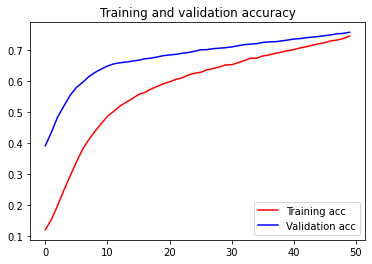

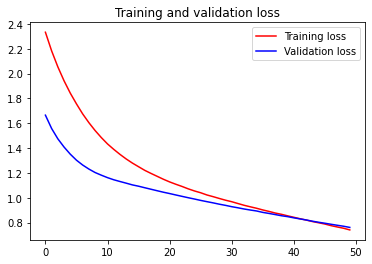

In [ ]:
fine_acc = fine_history.history['accuracy']
fine_val_acc = fine_history.history['val_accuracy']
fine_loss = fine_history.history['loss']
fine_val_loss = fine_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, fine_acc, 'r', label='Training acc')
plt.plot(epochs, fine_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, fine_loss, 'r', label='Training loss')
plt.plot(epochs, fine_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_accuracy = model_tun.evaluate(testing_dataset)
print("Test loss", test_loss)
print("Test accuracy",test_accuracy)

15/15 [==============================] - 7s 445ms/step - loss: 1.0969 - accuracy: 0.5979
Test loss 1.09690523147583
Test accuracy 0.5979381203651428


Now we are saving both the models build.

In [ ]:
model.save('/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/fine_tuning_with_RMSProp.h5')
model_tun.save('/content/gdrive/MyDrive/progetto/modello/keras-facenet/model/fine_tuning_all_unfreezed.h5')

## **Overall plot**
Now we can see the results comparison of both the model performed. Again, we can appreciate the improving of the finetuned model.

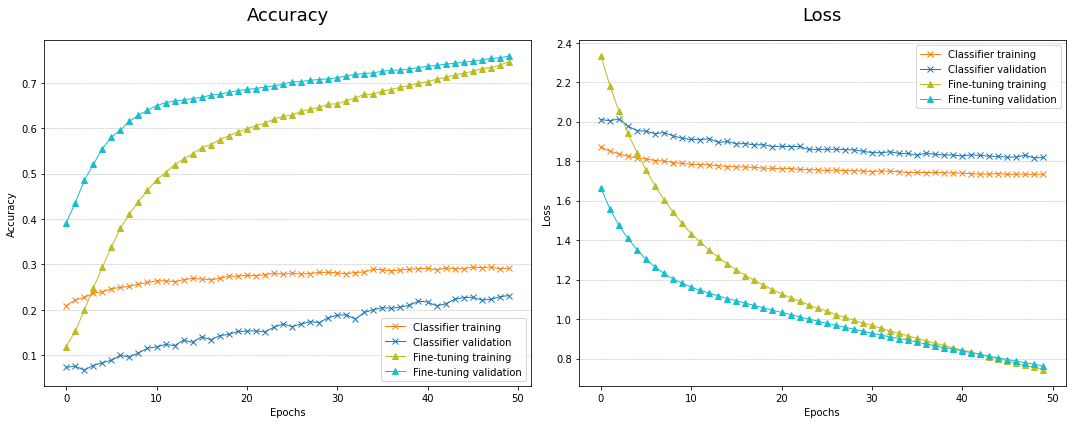

In [ ]:
# data from training with freezed mobilenet
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# data from fine-tuning training
ft_acc = fine_history.history['accuracy']
ft_val_acc = fine_history.history['val_accuracy']
ft_loss = fine_history.history['loss']
ft_val_loss = fine_history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs = range(len(acc))
epochs_1 = range(len(ft_acc))

# plot accuracy curves
acc_g.plot(epochs, acc, color='tab:orange', marker='x', linestyle='-', label='Classifier training', linewidth=1)
acc_g.plot(epochs, val_acc, color='tab:blue', marker='x', linestyle='-', label='Classifier validation', linewidth=1)
acc_g.plot(epochs_1, ft_acc, color='tab:olive', marker='^', linestyle='-', label='Fine-tuning training', linewidth=1)
acc_g.plot(epochs_1, ft_val_acc, color='tab:cyan', marker='^', linestyle='-', label='Fine-tuning validation', linewidth=1)

# plot loss curves
loss_g.plot(epochs, loss, color='tab:orange', marker='x', linestyle='-', label='Classifier training ', linewidth=1)
loss_g.plot(epochs, val_loss, color='tab:blue', marker='x', linestyle='-', label='Classifier validation', linewidth=1)
loss_g.plot(epochs_1, ft_loss, color='tab:olive', marker='^', linestyle='-', label='Fine-tuning training ', linewidth=1)
loss_g.plot(epochs_1, ft_val_loss, color='tab:cyan', marker='^', linestyle='-', label='Fine-tuning validation', linewidth=1)

# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18}, pad=20)
acc_g.legend(loc='lower right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()